<a href="https://colab.research.google.com/github/amimoon/AI_DeepLearning_Personal_Project/blob/main/%EA%B2%BD%EC%98%81%EC%9E%90%EB%A5%BC%EC%9C%84%ED%95%9CAI%EB%94%A5%EB%9F%AC%EB%8B%9D_%EA%B0%9C%EC%9D%B8%EA%B3%BC%EC%A0%9C_RoBerta_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kaggle Competition - Contradictory, My Dear Watson**


* Competition Title : Contradictory, My Dear Watson(Detecting contradiction and entailment in multilingual text using TPUs)
* Description : 다양한 언어(15개 언어)로 주어진 전제문장(Promise)와 가설문장(hypothesis) 간의 문맥을 파악하여 entailment(0), neutral(1), contradiction(2)로 분류하는 자연어 추론 문제
* Evaluation 지표 : accuracy

# **Kaggle Competiton Notebook**

* **Github Colne**

> guihub에 저장된 데이터 사용을 위해 Colab으로 Clone






In [1]:
%cd /content

/content


In [2]:
import os
if not os.path.exists('AI_DeepLearning_Personal_Project'):
  !git clone https://github.com/amimoon/AI_DeepLearning_Personal_Project.git

In [3]:
% cd /content/AI_DeepLearning_Personal_Project

/content/AI_DeepLearning_Personal_Project


* **Initial Settings**

In [4]:
!pip install transformers
!pip install sentencepiece

In [5]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt

import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score

import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel
from transformers import AdamW
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [7]:
'''
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    
print('Number of replicas:', strategy.num_replicas_in_sync)
'''

"\nimport tensorflow as tf\n\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nexcept ValueError:\n    strategy = tf.distribute.get_strategy() # for CPU and single GPU\n    \nprint('Number of replicas:', strategy.num_replicas_in_sync)\n"

*  **Data Load**

In [8]:
train = pd.read_csv("./Data/train.csv", header=0, delimiter=",")
test = pd.read_csv("./Data/test.csv", header=0, delimiter=",")
submission = pd.read_csv("./Data/sample_submission.csv", header=0, delimiter=",")

In [9]:
print("Train Shape", train.shape, "Test Shape", test.shape, "Submission Shape", submission.shape);

Train Shape (12120, 6) Test Shape (5195, 5) Submission Shape (5195, 2)


In [10]:
train.head(5)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


* **EDA**

> Label, 언어 별 데이터 분포 확인

In [11]:
temp = train.groupby('label').count()['id'].reset_index().sort_values(by='id',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,id
0,0,4176
2,2,4064
1,1,3880


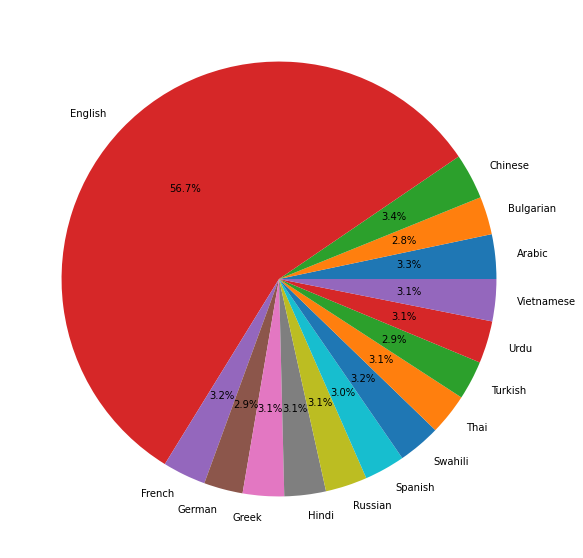

In [12]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

> Premise, hypothesis 문장 별 데이터 길이 분포 확인

In [13]:
train['premise_len'] = train['premise'].str.len()
train['hypothesis_len'] = train['hypothesis'].str.len()

In [14]:
#hist_data = pd.DataFrame()
hist_data = [train['premise_len'],train['hypothesis_len']]

group_labels = ['Premise', 'Hypothesis']

fig = ff.create_distplot(hist_data, group_labels, show_curve=False)
fig.update_layout(title_text='Distribution of Length Of Sentence')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

* **Preparing Data for Input**

> 언어별 Tokenize를 위해 roberta의 Pretrained 모델(joeddav/xlm-roberta-large-xnli의 AutoTokenizer 활용

> AutoTokenizer를 통해 Train 데이터의 아래 구조로 문장 Token 사이에 Sperator가 추가되어 데이터가 Tokenize됨

> [CLS] + Primise 문장 tokenize + [SEP] +  Hypothesis 문장 tokenize + [SEP]

In [15]:
!pip3 install sentencepiece

In [16]:
max_len = 50

tokenizer=AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli')
train_enc=tokenizer.batch_encode_plus(train[['premise','hypothesis']].values.tolist(),padding='max_length',max_length=max_len,truncation=True,return_attention_mask=True)
test_enc=tokenizer.batch_encode_plus(test[['premise','hypothesis']].values.tolist(),padding='max_length',max_length=max_len,truncation=True,return_attention_mask=True)
train_tf1=tf.convert_to_tensor(train_enc['input_ids'],dtype=tf.int32)
train_tf2=tf.convert_to_tensor(train_enc['attention_mask'],dtype=tf.int32)
train_input={'input_word_ids':train_tf1,'input_mask':train_tf2}
test_tf1=tf.convert_to_tensor(test_enc['input_ids'],dtype=tf.int32)
test_tf2=tf.convert_to_tensor(test_enc['attention_mask'],dtype=tf.int32)
test_input={'input_word_ids':test_tf1,'input_mask':test_tf2}

In [17]:
train_enc[100]

Encoding(num_tokens=50, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

* **Creating & Training Mode**

In [18]:
#strategy.scope():
input_ids = tf.keras.Input(shape = (max_len,), dtype = tf.int32,name='input_word_ids') 
input_mask=tf.keras.Input(shape=(max_len,),dtype=tf.int32,name='input_mask')    
roberta = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
roberta = roberta([input_ids,input_mask])[0]
out = tf.keras.layers.GlobalAveragePooling1D()(roberta)
out = tf.keras.layers.Dense(3, activation = 'softmax')(out)
model = tf.keras.Model(inputs = [input_ids,input_mask], outputs = out)
model.compile(
                    optimizer = tf.keras.optimizers.Adam(lr = 1e-5), 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics = ['accuracy']) 
model.summary()

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_input,train.label,
          validation_split=0.2, 
          epochs=10,
          batch_size=32,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/10


In [ ]:
# summarize history for loss
ep_nbr = np.arange(1, len(history.history['accuracy']) + 1)
plt.plot(ep_nbr, history.history['loss'])
plt.plot(ep_nbr, history.history['val_loss'])
plt.title('Unadjusted Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Training loss is continually reported over the course of an entire epoch.
# Validation metrics are computed over the validation set only once the current training epoch is completed.
# This implies, that on average, training losses are measured half an epoch earlier.

# plot the *shifted* training and validation loss
plt.plot(ep_nbr - 0.5, history.history['loss'], label="train_loss")
plt.plot(ep_nbr, history.history['val_loss'], label="val_loss")
plt.title("Shifted Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# summarize history for accuracy
plt.plot(ep_nbr, history.history['accuracy'])
plt.plot(ep_nbr, history.history['val_accuracy'])
plt.title('Unadjusted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot the *shifted* training and validation accuracy
plt.plot(ep_nbr - 0.5, history.history['accuracy'], label="train_accuracy")
plt.plot(ep_nbr, history.history['val_accuracy'], label="val_accuracy")
plt.title("Shifted Accuracy")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
test_encoded = tokenizer(test['premise'].tolist(), test_input['hypothesis'].tolist(), padding='max_length', return_tensors='tf')

In [ ]:
predictions = [np.argmax(i) for i in model.predict(test_encoded.data)]

In [ ]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [ ]:
submission['prediction'].value_counts()

In [ ]:
submission.head()